# Market Microstructure

- intraday liquidity, variance ratio, effective spreads, tick sign test
- tick data, NYSE Daily TAQ 

Terence Lim

In [1]:
import numpy as np
import pandas as pd
import time
import os
import pandas as pd
from pandas import DataFrame, Series
from matplotlib import colors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from finds.database import SQL, Redis
from finds.structured import CRSP
from finds.busday import BusDay
from finds.taq import opentaq, itertaq, open_t, close_t, bin_trades, bin_quotes
from finds.display import plot_time, row_formatted
from finds.solve import weighted_average
from settings import settings
sql = SQL(**settings['sql'])
user = SQL(**settings['user'])
bday = BusDay(sql)
rdb = Redis(**settings['redis'])
crsp = CRSP(sql, bday, rdb=rdb)
logdir = os.path.join(settings['images'], 'micro')  # None
taqdir = os.path.join(settings['remote'], 'TAQ')
_open = pd.to_datetime('1900-01-01T9:30')    # exclude <= 
_close = pd.to_datetime('1900-01-01T16:00')  # exclude >
tic = time.time()
intervals = [(v,'s') for v in [1,2,5,15,30]] + [(v,'m') for v in [1,2,5]]

## Display DailyTAQ trades and quotes for one sample stock

In [29]:
from finds.taq import clean_trade, clean_nbbo, align_trades, plot_taq
master, trades, quotes = opentaq(20191008, taqdir)
master

,Symbol,Security_Description,CUSIP,Security_Type,SIP_Symbol,Old_Symbol,Test_Symbol_Flag,Listed_Exchange,Tape,Unit_Of_Trade,...,TradedOnNYSE,TradedOnArca,TradedOnNasdaq,TradedOnCBOE,TradedOnPSX,TradedOnBATSY,TradedOnBATS,TradedOnIEX,Tick_Pilot_Indicator,Effective_Date
A,A,Agilent Technologies Inc.,00846U101,A,A,,N,N,A,4,...,1,1,1,0,1,1,1,1,,19991118
AA,AA,Alcoa Corporation,013872106,A,AA,,N,N,A,4,...,1,1,1,0,1,1,1,1,,20161018
AAAU,AAAU,Perth Mint Physical Gold ETF (Trust),715426102,ETF,AAAU,,N,P,B,1,...,1,1,1,0,0,0,1,0,,20180815
AAC,AAC,"AAC Holdings, Inc.",000307108,A,AAC,,N,N,A,4,...,1,1,1,0,0,1,1,1,,20141002
AADR,AADR,AdvisorShares Dorsey Wright ADR ETF,00768Y206,ETF,AADR,,N,P,B,1,...,0,1,1,0,0,0,0,0,,20100721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYME,ZYME,Zymeworks Inc.,98985W102,A,ZYME,,N,N,A,4,...,1,1,1,0,1,1,1,1,,20170428
ZYNE,ZYNE,"Zynerba Pharmaceuticals, Inc",98986X109,A,ZYNE,,N,Q,C,1,...,1,1,1,0,1,1,1,1,,0
ZYXI,ZYXI,ZYNEX INC,98986M103,A,ZYXI,,N,Q,C,1,...,1,1,1,0,1,1,1,1,,0
ZZK,ZZK,NYSE Arca Listed Test Stock For CTS CQS,,U,ZZK,,Y,P,B,1,...,0,0,0,0,0,0,0,0,,0


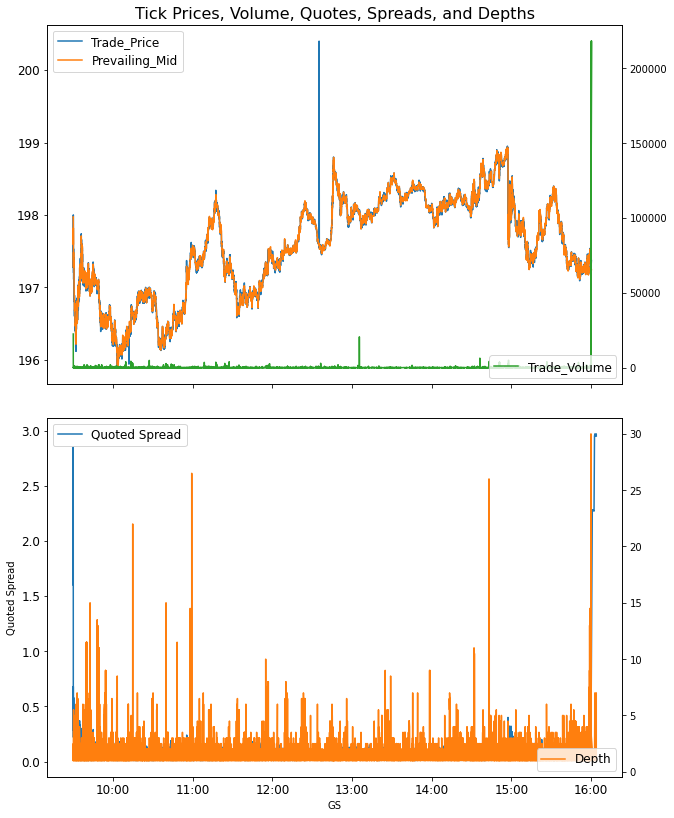

In [36]:
    symbol = 'GS'
    t = trades[symbol]
    q = quotes[symbol]
    ct = clean_trade(t, close_t=close_t + np.timedelta64('5','m'))
    cq = clean_nbbo(q)    
    align_trades(ct, cq, inplace=True)

    plot_taq(ct[['Trade_Price', 'Prevailing_Mid']], ct['Trade_Volume'],
             (cq['Best_Offer_Price'] - cq['Best_Bid_Price'])\
             .rename('Quoted Spread'),
             ((cq['Best_Bid_Size']+cq['Best_Offer_Size'])/2).rename('Depth'),
             open_t=open_t, close_t=close_t + np.timedelta64('5','m'), num=1,
             title=f"Tick Prices, Volume, Quotes, Spreads, and Depths")
    plt.show()  

## Transform to 5-minute bins and display for same example

Correlation of MidQuote and LastTrade 5m-bin returns


,ret,retq
ret,1.000000,0.987613
retq,0.987613,1.000000


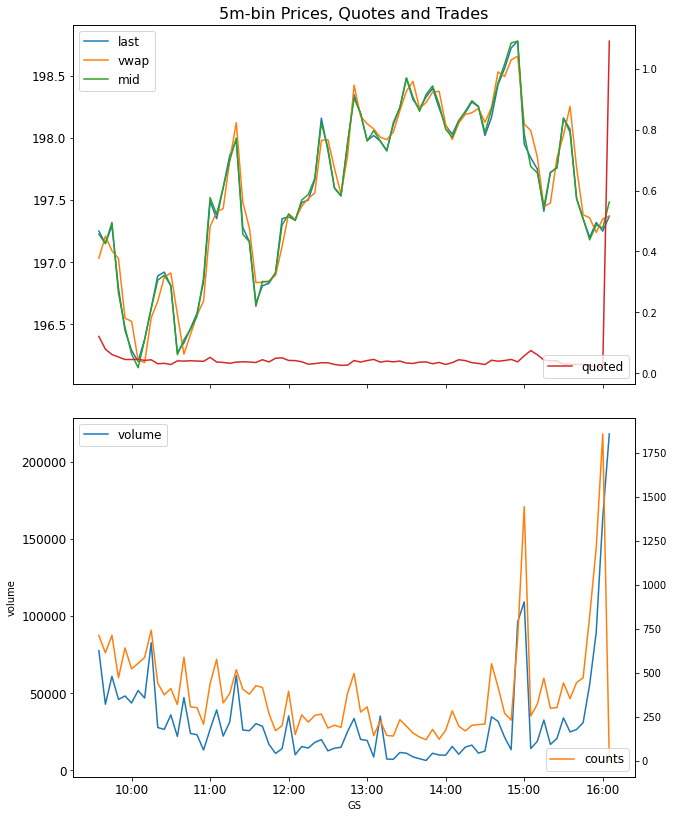

In [37]:
    value, unit = 5, 'm'
    timedelta = np.timedelta64(value, unit)
    bt = bin_trades(ct, value, unit, close_t=close_t + timedelta)
    bq = bin_quotes(cq, value, unit, close_t=close_t + timedelta)
    bq = bq.join(bt, how = 'left')
    plot_taq(bq[['last', 'vwap', 'mid']], bq['quoted'],
             bt['volume'], bt['counts'], num=2,
             open_t=open_t, close_t=close_t + np.timedelta64('5','m'),
             title=f"{value}{unit}-bin Prices, Quotes and Trades")
    print(f"Correlation of MidQuote and LastTrade {value}{unit}-bin returns")
    bq[['ret', 'retq']].corr()

In [42]:
bt[['volume','counts']].sum(axis=0)

volume    2572496.0
counts      30661.0
dtype: float64

## Loop through the sample TAQ data dates available from NYSE and collect info


In [ ]:
dates = [20191007, 20191008, 20180305, 20180306]
shareclass = []
daily = []
bins = {k:{} for k in ['effective', 'realized', 'impact', 'quoted', 'volume',
                       'offersize', 'bidsize', 'ret', 'retq', 'counts']}
tic = time.time()
for d, date in enumerate(dates):
    master, trades, quotes = opentaq(date, taqdir)

    # screen on CRSP universe, and drop duplicate share classes (same permco)
    univ = crsp.get_universe(date)\
               .join(crsp.get_section(dataset='names',
                                      fields=['ncusip', 'permco', 'exchcd'],
                                      date_field='date',
                                      date=date,
                                      start=0), how='inner')\
               .sort_values(['permco', 'ncusip'])
    dups = master['CUSIP'].str.slice(0, 8).isin(
        univ.loc[univ.duplicated(['permco'], keep=False), 'ncusip'])
    shareclass.extend(master[dups].to_dict(orient='index').values())
    univ = univ.sort_values(['permco','cap'], na_position='first')\
               .drop_duplicates(['permco'], keep='last')\
               .reset_index().set_index('ncusip', drop=False)

    # Iterate by symbol over Daily Taq trades, nbbo and master files
    for ct, cq, m in itertaq(trades, quotes, master, cusips=univ['ncusip'],
                             open_t=_open, close_t=None):
        h = {'date':date}
        h.update(univ.loc[m['CUSIP'][:8], ['permno','decile','exchcd','siccd']])
        h.update(m[['Symbol', 'Round_Lot']])

        # Compute and collect daily bin statistics at all intervals
        collect = h.copy()
        v, u = intervals[-1]
        for (v, u) in intervals:
            bt = bin_trades(ct, v, u, open_t=_open, close_t=_close)
            bq = bin_quotes(cq, v, u, open_t=_open, close_t=_close)
            collect[f"tvar{v}{u}"] = bt['ret'].var(ddof=0) * len(bt)
            collect[f"qvar{v}{u}"] = bq['retq'].var(ddof=0) * len(bq)
            collect[f"tunch{v}{u}"] = np.mean(np.abs(bt['ret']) < 1e-15)
            collect[f"qunch{v}{u}"] = np.mean(np.abs(bq['retq']) < 1e-15)
            collect[f"tzero{v}{u}"] = np.mean(bt['counts'] == 0)

        # Collect final set of bt and bq intradaily series
        df = bq.join(bt, how='left')
        for s in ['effective', 'realized', 'impact', 'quoted']:
            bins[s].update({**h, **(df[s]/df['mid']).to_dict()})
        for s in ['volume', 'offersize', 'bidsize', 'ret', 'retq', 'counts']:
            bins[s].update({**h, **df[s].to_dict()})
        #print(date, d, len(daily), int(time.time()-tic), 'secs')

        # Collect daily means
        collect.update(df[['bidsize', 'offersize', 'quoted', 'mid']].mean())
        collect.update(df[['volume', 'counts']].sum())
        collect.update(weighted_average(df[['effective', 'impact', 'realized',
                                            'vwap', 'volume']],
                                        weights='volume', axis=0))
        daily.append(collect)
    quotes.close()
    trades.close()
    #print(d, date, time.time() - tic)

daily_df = DataFrame(daily)
bins_df = {k: DataFrame(bins[k]) for k in bins.keys()}

In [5]:
from settings import pickle_load
daily_df = pickle_load('tick.daily')

### Daily Average Liquidity -- median by market size and exchange listed

In [6]:
# Group by market cap and exchange
daily_df['Size'] = pd.cut(daily_df['decile'], [0, 3.5, 6.5, 9.5, 11],
                          labels=['large', 'medium', 'small', 'tiny'])
daily_df['Exchange'] = pd.cut(daily_df['exchcd'], [0, 2.5, 4],
                              labels=['NYSE','NASDAQ'])
g = daily_df.groupby(['Size', 'Exchange'])

results = {}    # to collect results as dict of {column: Series}
formatter = {}  # and associated format string
results.update(g['mid'].count().rename('Number of Stock/Days').to_frame())
formatter.update({'Number of Stock/Days': '{:.0f}'})

result = g[['mid', 'vwap']].median()   # .quantile(), and range
result.columns = ['Midquote Price', "VWAP"]
formatter.update({k: '{:.2f}' for k in result.columns})
results.update(result)

result = g[['counts', 'volume']].median()
result.columns = ['Number of trades', "Volume (shares)"]
formatter.update({k: '{:.0f}' for k in result.columns})
results.update(result)

result = g[['offersize', 'bidsize']].median()
result.columns = [s.capitalize() + ' (lots)' for s in result.columns]
formatter.update({k: '{:.1f}' for k in result.columns})
results.update(result)

spr = ['quoted', 'effective', 'impact', 'realized']
result = g[spr].median()
result.columns = [s.capitalize() + ' $ spread' for s in spr]
formatter.update({k: '{:.4f}' for k in result.columns})
results.update(result)

rel = [s.capitalize() + ' (% price)' for s in spr]
daily_df[rel] = daily_df[spr].div(daily_df['mid'], axis=0)  # scale spreads
result = 100*g[rel].median()
formatter.update({k: '{:.4f}' for k in result.columns})
results.update(result)

## display table of results
row_formatted(DataFrame(results).T, formatter)

Size                    large           medium           small          \
Exchange                 NYSE   NASDAQ    NYSE  NASDAQ    NYSE  NASDAQ   
Number of Stock/Days     1439      630    1445    1138    1499    2821   
Midquote Price          79.44    92.90   44.51   46.95   19.46   21.46   
VWAP                    79.40    92.85   44.47   46.87   19.49   21.43   
Number of trades        17307    17684    6333    5422    2635    1873   
Volume (shares)       1443707  1336484  482203  384135  233496  149803   
Offersize (lots)          2.1      2.0     2.1     1.9     2.7     2.2   
Bidsize (lots)            2.1      2.0     2.1     2.0     2.8     2.3   
Quoted $ spread        0.0183   0.0292  0.0257  0.0387  0.0258  0.0392   
Effective $ spread     0.0096   0.0176  0.0115  0.0198  0.0129  0.0203   
Impact $ spread        0.0083   0.0146  0.0100  0.0150  0.0103  0.0141   
Realized $ spread      0.0012   0.0023  0.0016  0.0028  0.0016  0.0036   
Quoted (% price)       0.0264   0.0308  0.0596  0.0795  0.1319  0.1750   
Effective (% price)    0.0144   0.0196  0.0285  0.0396  0.0709  0.0952   
Impact (% price)       0.0125   0.0167  0.0256  0.0330  0.0597  0.0707   
Realized (% price)     0.0019   0.0030  0.0038  0.0072  0.0102  0.0190   

Size                    tiny          
Exchange                NYSE  NASDAQ  
Number of Stock/Days    1020    3635  
Midquote Price          3.70    4.34  
VWAP                    3.71    4.31  
Number of trades         345     226  
Volume (shares)        51565   33024  
Offersize (lots)         4.9     4.5  
Bidsize (lots)           5.0     5.0  
Quoted $ spread       0.0186  0.0315  
Effective $ spread    0.0111  0.0181  
Impact $ spread       0.0043  0.0054  
Realized $ spread     0.0037  0.0073  
Quoted (% price)      0.5784  0.7410  
Effective (% price)   0.3747  0.4522  
Impact (% price)      0.1329  0.1481  
Realized (% price)    0.1598  0.2245

### Helper to plot result summary comparisons


In [17]:
def plot_helper(result, xticks, keys, legend, xlabel, title, num=1):
    fig, ax = plt.subplots(num=num, clear=True, figsize=(8,5))
    result.plot(kind='bar', fontsize=14, rot=0, width=0.8, xlabel='', ax=ax)
    ax.set_xticklabels(xticks, fontsize=14)
    ax.legend(keys, loc='upper left', bbox_to_anchor=(1.0, 1.0), 
              fontsize=11, title=legend, title_fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    plt.subplots_adjust(right=0.85)
    return ax    
xticks = [f"{v}{u}" for v, u in intervals]
keys = [a + '\n' + b for a,b in g.indices.keys()]

### Summarize unchanged midquote and last trade price, and zero-volume bins

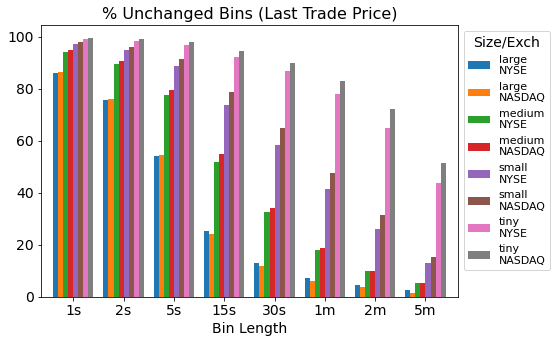

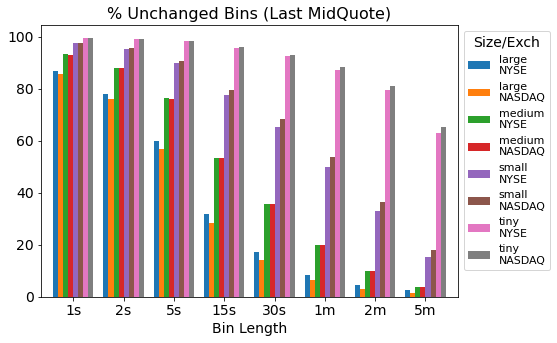

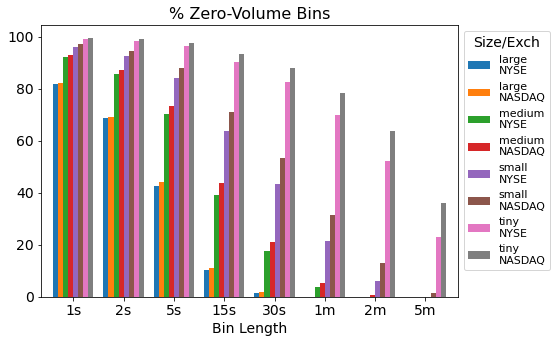

In [18]:
labels = [f"tunch{v}{u}" for v, u in intervals]
result = g[labels].median()*100
ax = plot_helper(result.T, title="% Unchanged Bins (Last Trade Price)",
                 xticks=xticks, xlabel="Bin Length",
                 keys=keys, legend='Size/Exch', num=1)
plt.savefig(os.path.join(logdir, 'tunch.jpg'))

labels = [f"qunch{v}{u}" for v, u in intervals]
result = g[labels].median()*100
ax = plot_helper(result.T, title="% Unchanged Bins (Last MidQuote)",
                 xticks=xticks, xlabel="Bin Length",
                 keys=keys, legend='Size/Exch', num=2)
plt.savefig(os.path.join(logdir, 'qunch.jpg'))

labels = [f"tzero{v}{u}" for v, u in intervals]
result = g[labels].median()*100
ax = plot_helper(result.T, title="% Zero-Volume Bins",
                 xticks=xticks, xlabel="Bin Length",
                 keys=keys, legend='Size/Exch', num=3)
plt.savefig(os.path.join(logdir, 'tzero.jpg'))

### Variance Ratios

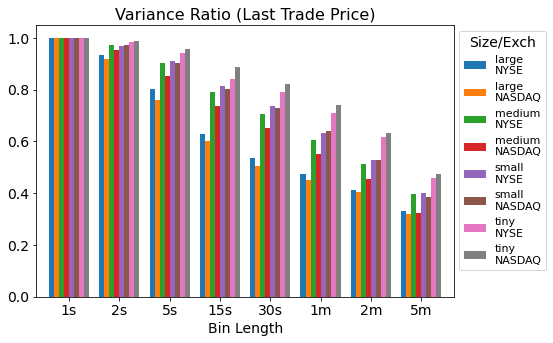

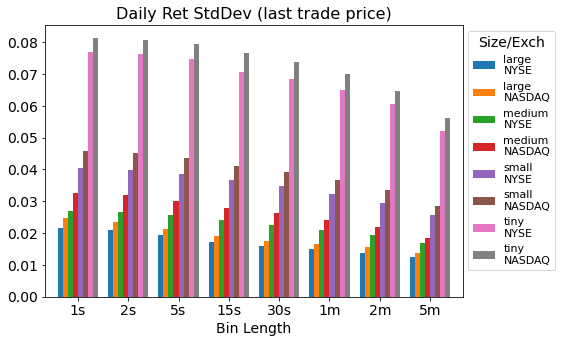

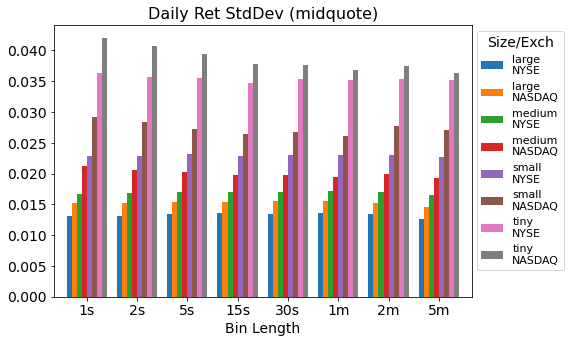

In [19]:
labels = [f"tvar{v}{u}" for v, u in intervals]
result = g[labels].median()
result = result.div(result['tvar1s'].values, axis=0)
ax = plot_helper(result.T, title="Variance Ratio (Last Trade Price)",
                 xticks=xticks, xlabel="Bin Length",
                 keys=keys, legend='Size/Exch', num=4)
plt.savefig(os.path.join(logdir, 'tvratio.jpg'))
    
labels = [f"tvar{v}{u}" for v, u in intervals]
result = np.sqrt(g[labels].median())
ax = plot_helper(result.T, title="Daily Ret StdDev (last trade price)",
                 xticks=xticks, xlabel="Bin Length",
                 keys=keys, legend='Size/Exch', num=5)
plt.savefig(os.path.join(logdir, 'tstd.jpg'))

labels = [f"qvar{v}{u}" for v, u in intervals]
result = np.sqrt(g[labels].median())
ax = plot_helper(result.T, title="Daily Ret StdDev (midquote)",
                 xticks=xticks, xlabel="Bin Length",
                 keys=keys, legend='Size/Exch', num=6)
plt.savefig(os.path.join(logdir, 'qstd.jpg'))

### Intraday spreads, depths and volumes

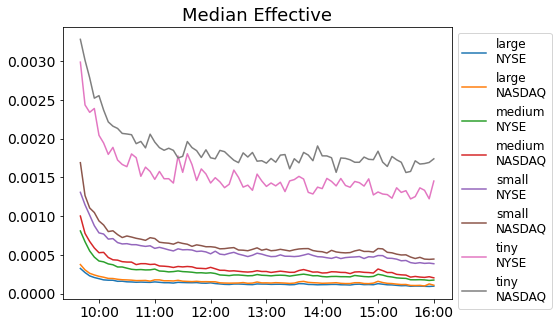

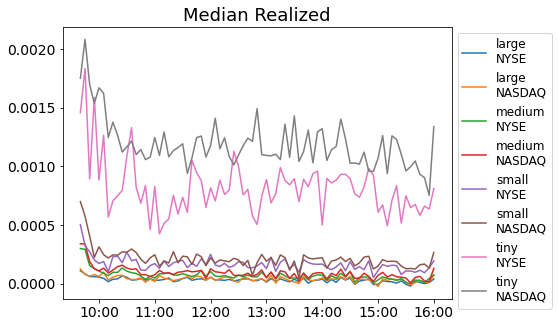

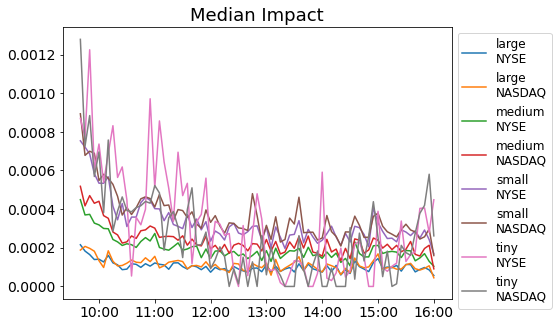

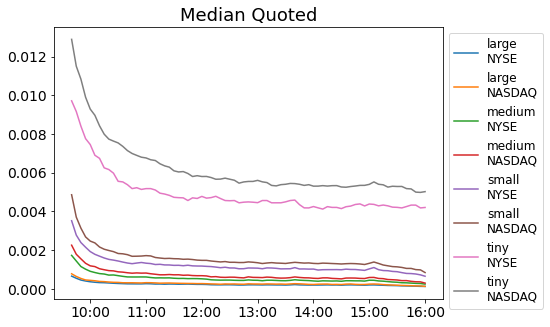

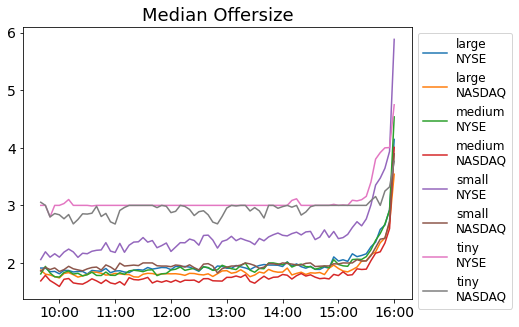

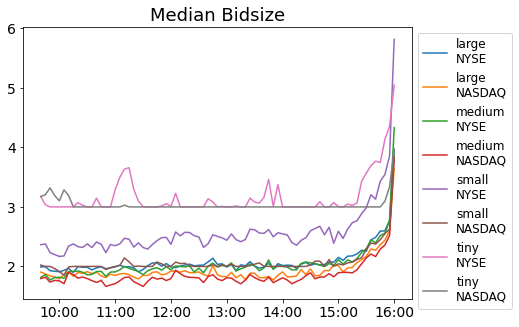

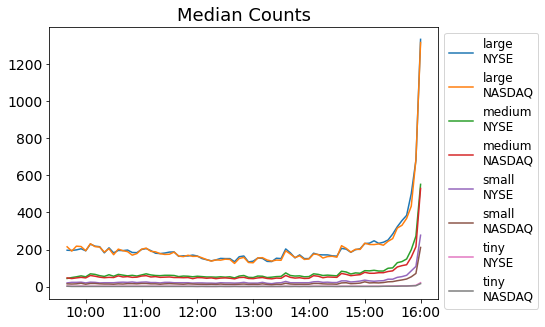

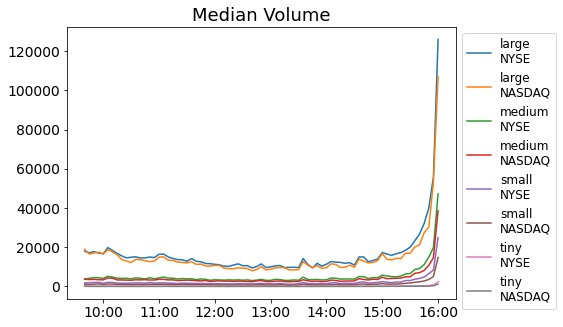

In [24]:
keys = ['effective', 'realized', 'impact', 'quoted', 
        'offersize', 'bidsize', 'counts', 'volume']

for num, key in enumerate(keys):
    df = bins_df[key].drop(columns=['Round_Lot', 'Symbol'])
    df.index = list(zip(df['permno'], df['date']))
        
    # Group by market cap and exchange
    df['Size'] = pd.cut(df['decile'], [0, 3.5, 6.5, 9.5, 11],
                        labels=['large', 'medium', 'small', 'tiny'])
    df['Exchange'] = pd.cut(df['exchcd'], [0, 2.5, 4],
                            labels=['NYSE','NASDAQ'])
    df = df.drop(columns=['date', 'permno', 'decile', 'exchcd', 'siccd'])\
           .dropna().groupby(['Size', 'Exchange']).median().T
    fig, ax = plt.subplots(1, 1, num=num+1, clear=True, figsize=(8,5))
    plot_time(df.iloc[1:], title='Median '+key.capitalize(), ax=ax, 
              fontsize=14, loc='upper center', legend1=None)
    ax.legend([a + '\n' + b for a,b in df.columns], 
              loc='upper left', bbox_to_anchor=(1.0, 1.0), 
              fontsize=12)
    plt.subplots_adjust(right=0.8)
    plt.savefig(os.path.join(logdir, key + '.jpg'))